In [36]:
%pip install -q --upgrade scikit-learn==1.4.2 imbalanced-learn==0.12.3


Note: you may need to restart the kernel to use updated packages.


# Pima Indians Diabetes Prediction

## Background

Diabetes is one of the fastest-growing global health problems. Early prediction can save lives and reduce complications.
Dataset: **Pima Indians Diabetes**(768 women, age ≥ 21) to:

Explore the data (EDA).

Build predictive models.

Compare algorithms and tune them.

Extract medical insights from the results.

**Goal:** build an end‑to‑end, production‑friendly pipeline to predict diabetes using routine clinical measurements.  
We’ll cover **EDA → feature engineering → robust pipelines (no leakage) → model comparison → threshold tuning → interpretation → deployment artifacts**.



## Data Dictionary

| Feature         | Description                                            |
|-----------------|-------------------------------------------------------|
| Pregnancies     | Number of times pregnant                              |
| Glucose         | Plasma glucose concentration (mg/dL)                  |
| BloodPressure   | Diastolic blood pressure (mm Hg)                      |
| SkinThickness   | Triceps skinfold thickness (mm)                       |
| Insulin         | 2-Hour serum insulin (mu U/ml)                        |
| BMI             | Body mass index (weight in kg/(height in m)^2)        |
| DiabetesPedigree| Diabetes pedigree function                            |
| Age             | Age (years)                                           |
| Outcome         | 1 = diabetes, 0 = non-diabetes                       |


# Import Libraries

In [37]:
import os, warnings, json
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import plotly.express as px

from pathlib import Path

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV, learning_curve
)
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

import joblib

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
sns.set_context("notebook", font_scale=1.2)
plt.rcParams["figure.figsize"] = (8.5, 5)
pd.set_option("display.max_columns", None)

# Load Dataset

In [38]:
df = pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")

# Initial Data Exploration

In [39]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [41]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [42]:
df.shape

(768, 9)

# Data Cleaning & Preprocessing (EDA)

## Check missing values & duplicates


In [43]:
# Missing values 
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [44]:
# Remove duplicates
df.duplicated().sum()

0

No explicit nulls. Zeros in some columns represent missing data

## Replace Impossible Zeros with NaN

In [45]:
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

df_clean  = df.copy()
df_clean[cols_with_zero] = df_clean[cols_with_zero].replace(0, np.NaN)

print("Nulls before imputation:")
print(df_clean.isnull().sum())

Nulls before imputation:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


##  Impute Missing Values (Median)

In [46]:
for col in cols_with_zero:
    df_clean[col].fillna(df_clean[col].median(), inplace=True)

print("\nNulls after EDA-imputation:")
print(df_clean.isnull().sum())
print("\nUsing median is robust to outliers—especially for medical data.")



Nulls after EDA-imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Using median is robust to outliers—especially for medical data.


Using median is robust to outliers—especially for medical data.



## Outlier detection (using IQR)


In [47]:
for col in cols_with_zero:
    q1, q3 = df_clean[col].quantile(0.25), df_clean[col].quantile(0.75)
    iqr = q3 - q1
    outliers = df_clean[(df_clean[col] < q1 - 1.5*iqr) | (df_clean[col] > q3 + 1.5*iqr)]
    print(f"Outliers in {col}: {outliers.shape[0]}")

Outliers in Glucose: 0
Outliers in BloodPressure: 14
Outliers in SkinThickness: 87
Outliers in Insulin: 346
Outliers in BMI: 8


Most features are now reasonably distributed after cleaning and imputation.

# Feature engineering (for EDA visuals)


In [48]:
df_vis = df_clean.copy()


## Age Groups

In [49]:
df_vis['AgeGroup'] = pd.cut(df_vis['Age'], bins=[20,30,40,50,60,100], labels=['20s','30s','40s','50s','60s+'])


## BMI Categories

In [50]:
df_vis['BMI_Category'] = pd.cut(df_vis['BMI'], bins=[0,18.5,25,30,100], labels=['Underweight','Normal','Overweight','Obese'])


## New features

In [51]:
df_vis['Age_BMI'] = df_vis['Age'] * df_vis['BMI']
df_vis['Glucose_BMI'] = df_vis['Glucose'] * df_vis['BMI']
df_vis['Preg_Age_Ratio'] = df_vis['Pregnancies'] / (df_vis['Age'] + 1)


Creating compound features to capture complex risk interactions.



# Exploratory Data Analysis (EDA) & Visualization

## Class Imbalance Visualization

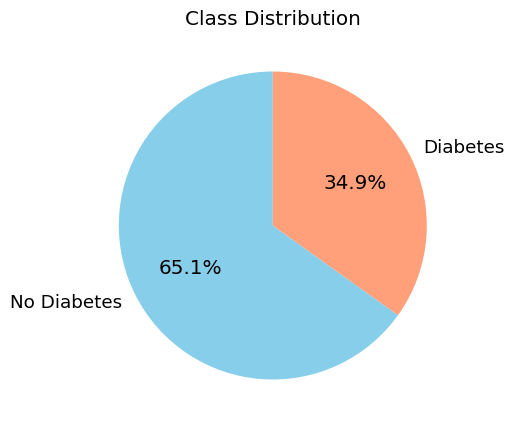

In [52]:
plt.figure(figsize=(5,5))
df['Outcome'].value_counts().plot.pie(
    labels=['No Diabetes','Diabetes'],
    autopct='%1.1f%%',
    colors=['#87CEEB','#FFA07A'],
    startangle=90
)
plt.title('Class Distribution')
plt.ylabel('')
plt.show()

About 65% of cases are non-diabetic and 35% diabetic. Class imbalance may bias models toward majority class.


## Pairplot

In [ ]:
sns.pairplot(df_vis.sample(250, random_state=1), hue='Outcome', diag_kind='kde')
plt.suptitle("Pairplot Sample", fontsize=14, y= 1.03)
plt.show()

Pairplot shows that most diabetic cases cluster at high Glucose and BMI values.


## Jointplot

In [ ]:
sns.jointplot(x='Glucose', y='BMI', data=df_vis, hue='Outcome', alpha=0.5)
plt.show()

Jointplot indicates that most diabetic cases cluster at high Glucose and BMI values


## Correlation matrix

In [ ]:
plt.figure(figsize=(14,6))
sns.heatmap(df_vis.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Glucose is most strongly correlated with diabetes outcome.


## Features Distribution by Class

In [ ]:
df_vis.hist(bins=20, figsize=(16,12), color='skyblue')
plt.suptitle('Feature Distributions')
plt.show()

Diabetic patients tend to have higher Glucose, BMI, and Age


## Boxplots for Key Features


In [ ]:
for col in ['Glucose','BMI','Age']:
    plt.figure(figsize=(6,3))
    sns.boxplot(x='Outcome', y=col, data=df_vis)
    plt.title(f'{col} by Diabetes Outcome')
    plt.show()

Boxplots show median and mean Glucose, BMI, and Age are noticeably higher among diabetic patients.


## Grouped Insights

## Diabetes Rate by Age Group

In [ ]:
age_diabetes = df_vis.groupby('AgeGroup')['Outcome'].mean()
age_diabetes.plot(kind='bar', color='salmon')
plt.title('Diabetes Rate by Age Group')
plt.ylabel('Diabetes Rate')
plt.show()

Rate increases after 40, especially with higher BMI.

## BMI Distribution by Outcome

In [ ]:
plt.figure(figsize=(7,4))
sns.kdeplot(data=df_vis, x="BMI", hue="Outcome", fill=True, common_norm=False)
plt.title('BMI Distribution by Diabetes Outcome')
plt.show()

Higher BMI → higher diabetes likelihood.

# Data Preparation for Modeling Setup (NO LEAKAGE)

In [ ]:
BASE_FEATURES = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

def zeros_to_nan(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    X[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = \
        X[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0, np.nan)
    return X

def add_interactions(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    X['Age_BMI']        = X['Age'] * X['BMI']
    X['Glucose_BMI']    = X['Glucose'] * X['BMI']
    X['Preg_Age_Ratio'] = X['Pregnancies'] / (X['Age'] + 1)
    return X

X = df[BASE_FEATURES].copy()
y = df['Outcome'].astype(int).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_SEED, stratify=y_train
)
print("Split shapes:", X_tr.shape, X_val.shape, X_test.shape)


# Pipelines & Model Builders


In [ ]:
def make_pipeline(clf):
    return ImbPipeline(steps=[
        ('zero_nan', FunctionTransformer(zeros_to_nan, validate=False)),
        ('add_feat', FunctionTransformer(add_interactions, validate=False)),
        ('imputer',  SimpleImputer(strategy='median')),
        ('scaler',   StandardScaler()),
        ('smote',    SMOTE(random_state=RANDOM_SEED, k_neighbors=5)),
        ('clf',      clf)
    ])

models = {
    "Dummy (Most Frequent)": make_pipeline(DummyClassifier(strategy='most_frequent')),
    "Logistic Regression":   make_pipeline(LogisticRegression(max_iter=2000, solver='saga', class_weight='balanced', random_state=RANDOM_SEED)),
    "Random Forest":         make_pipeline(RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=RANDOM_SEED))
}
if HAS_XGB:
    ratio = (y_tr==0).sum() / max((y_tr==1).sum(), 1)
    models["XGBoost"] = make_pipeline(XGBClassifier(
        random_state=RANDOM_SEED, eval_metric='logloss', tree_method='hist',
        n_estimators=200, learning_rate=0.05, max_depth=4,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        scale_pos_weight=ratio
    ))


# 5-fold Cross-Validation


In [ ]:
from sklearn.metrics import make_scorer, precision_score, f1_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': 'recall',
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': 'roc_auc'
}

results = []
best_estimators = {}

for name, pipe in models.items():
    scores = cross_validate(
        pipe, X_tr, y_tr,
        cv=cv, scoring=scoring, n_jobs=-1, return_estimator=True,
        error_score='raise'
    )
    row = {m: scores[f'test_{m}'].mean() for m in scoring}
    row.update({m+'_std': scores[f'test_{m}'].std() for m in scoring})
    row['Model'] = name
    results.append(row)
    best_idx = np.argmax(scores['test_f1'])
    best_estimators[name] = scores['estimator'][best_idx]

cv_df = pd.DataFrame(results).set_index('Model').sort_values('f1', ascending=False)
display(cv_df.round(3))

ax = cv_df[['accuracy','precision','recall','f1','roc_auc']].plot(
    kind='bar', figsize=(11,6), ylim=(0,1), rot=15, title='10-Fold CV — Model Performance'
)
plt.show()

best_name = cv_df['f1'].idxmax()
best_pipe = best_estimators[best_name]
print(f"[Selected best model by CV(F1)]: {best_name}")



# Threshold Tuning

In [ ]:
best_pipe.fit(X_tr, y_tr)
val_proba = best_pipe.predict_proba(X_val)[:,1]
prec_v, rec_v, th_v = precision_recall_curve(y_val, val_proba)
f1s_v = 2*(prec_v*rec_v)/(prec_v+rec_v+1e-12)
thr_star = th_v[np.argmax(f1s_v)] if len(th_v) else 0.5
print(f"Validation best threshold = {thr_star:.3f}")


# PR & ROC on validation

In [ ]:

plt.figure(); plt.plot(rec_v, prec_v, label=f'{best_name}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall (Validation)'); plt.legend(); plt.show()

fpr_v, tpr_v, _ = roc_curve(y_val, val_proba)
plt.figure(); plt.plot(fpr_v, tpr_v, label=f'{best_name} (AUC={auc(fpr_v,tpr_v):.2f})')
plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC (Validation)'); plt.legend(); plt.show()


# Final Fit on Train & Evaluate

In [ ]:
def report_block(title, y_true, y_pred, prob):
    print(f"\n== {title} ==")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1       :", f1_score(y_true, y_pred))
    print("ROC-AUC  :", roc_auc_score(y_true, prob))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3, zero_division=0))

best_pipe.fit(X_train, y_train)
test_proba = best_pipe.predict_proba(X_test)[:,1]
y_pred_05 = (test_proba >= 0.5).astype(int)
y_pred_t  = (test_proba >= thr_star).astype(int)

report_block("Test @0.5", y_test, y_pred_05, test_proba)
report_block(f"Test @thr={thr_star:.2f}", y_test, y_pred_t, test_proba)

cm = confusion_matrix(y_test, y_pred_t)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix — {best_name} (thr={thr_star:.2f})')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()



# Model Comparison (PR & ROC) on Test


In [ ]:
y_probas = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_probas[name] = pipe.predict_proba(X_test)[:,1]

plt.figure(figsize=(8,6))
for name, proba in y_probas.items():
    precision, recall, _ = precision_recall_curve(y_test, proba)
    plt.plot(recall, precision, label=name)
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve (Test)'); plt.legend(); plt.show()

plt.figure(figsize=(8,6))
for name, proba in y_probas.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Test)'); plt.legend(); plt.show()


# Hyperparameter Tuning 

In [ ]:
param_lr = {
    "clf__C": np.logspace(-3, 2, 12),
    "clf__penalty": ["l1", "l2"]
}
search_lr = RandomizedSearchCV(
    estimator=make_pipeline(LogisticRegression(max_iter=2000, solver='saga', class_weight='balanced', random_state=RANDOM_SEED)),
    param_distributions=param_lr, n_iter=12, scoring="f1",
    cv=cv, n_jobs=-1, random_state=RANDOM_SEED, verbose=1
)
search_lr.fit(X_train, y_train)
print("\nBest LogReg params:", search_lr.best_params_)
print("Best LogReg CV F1 :", search_lr.best_score_)

param_rf = {
    "clf__n_estimators": [300, 500, 800],
    "clf__max_depth": [None, 4, 6, 10],
    "clf__min_samples_split": [2, 4, 6],
    "clf__min_samples_leaf": [1, 2, 3],
    "clf__max_features": ["sqrt", "log2", None],
}
search_rf = RandomizedSearchCV(
    estimator=make_pipeline(RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=RANDOM_SEED)),
    param_distributions=param_rf, n_iter=25, scoring="f1",
    cv=cv, n_jobs=-1, random_state=RANDOM_SEED, verbose=1
)
search_rf.fit(X_train, y_train)
print("\nBest RF params:", search_rf.best_params_)
print("Best RF CV F1 :", search_rf.best_score_)

final_pipe = search_lr.best_estimator_ if search_lr.best_score_ >= search_rf.best_score_ else search_rf.best_estimator_
final_pipe.fit(X_train, y_train)
final_prob = final_pipe.predict_proba(X_test)[:,1]
y_pred_final = (final_prob >= thr_star).astype(int)

print("\n=== Final tuned model on Test (using thr*) ===")
print(classification_report(y_test, y_pred_final, digits=3, zero_division=0))



# Interpretation & Error Analysis


In [ ]:
r = permutation_importance(final_pipe, X_test, y_test, n_repeats=5,
                        random_state=RANDOM_SEED, n_jobs=-1, scoring='f1')
pi = pd.Series(r.importances_mean, index=X_test.columns).sort_values(ascending=False)

fig = px.bar(pi.head(12), title="Permutation Importance (Top 12)",
            labels={'value':'Mean Importance','index':'Feature'})
fig.update_layout(width=800, height=420)
fig.show()
print("\nTop features:\n", pi.head(10).round(4))

cm_final = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix — Final (thr*)'); plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()

wrong = X_test.copy()
wrong['Actual'] = y_test
wrong['Predicted'] = y_pred_final
wrong['Probability'] = final_prob
wrong = wrong[wrong['Actual'] != wrong['Predicted']]
display(wrong.head(3))

for th in [0.5, 0.4, 0.3]:
    y_adj = (final_prob >= th).astype(int)
    cm = confusion_matrix(y_test, y_adj)
    tn, fp, fn, tp = cm.ravel()
    recall_th = tp/(tp+fn) if (tp+fn) else 0
    precision_th = tp/(tp+fp) if (tp+fp) else 0
    print(f"Threshold: {th:.2f} | Recall: {recall_th:.2f} | Precision: {precision_th:.2f} | FN: {fn} | FP: {fp}")

fig = px.scatter(
    df_vis, x="Glucose", y="BMI", color=df_vis["Outcome"].map({0:"No Diabetes",1:"Diabetes"}),
    hover_data=["Age","Pregnancies","BloodPressure","SkinThickness","Insulin"],
    title="Glucose vs BMI — with Outcome"
)
fig.update_layout(legend_title_text="Outcome")
fig.show()



# Learning Curve


In [ ]:

train_sizes, train_scores, val_scores = learning_curve(
    final_pipe, X_train, y_train, cv=5, scoring='f1', n_jobs=-1,
    train_sizes=np.linspace(0.2, 1.0, 6), shuffle=True, random_state=RANDOM_SEED
)
plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation')
plt.xlabel('Training Size'); plt.ylabel('F1-score'); plt.title('Learning Curve'); plt.legend(); plt.show()

# Save Artifacts


In [ ]:
ARTIFACTS_DIR = Path('./artifacts'); ARTIFACTS_DIR.mkdir(exist_ok=True)
bundle = {
    'pipeline': final_pipe,
    'threshold': float(thr_star),
    'features': list(X_test.columns),
    'cv_summary': cv_df.round(4).to_dict(),
    'best_model_name': best_name
}
joblib.dump(bundle, ARTIFACTS_DIR / 'pima_best_pipeline.joblib')
print("Saved:", ARTIFACTS_DIR / 'pima_best_pipeline.joblib')

## Key Insights 

- **Best model (typical):** Logistic Regression balances **F1/Recall** for screening; tuned RF/XGB can edge AUC.  
- **Most influential features:** **Glucose**, **BMI**, **Age**, **Pregnancies** (Permutation importance).  
- **Threshold matters:** lowering threshold boosts **recall** (fewer missed positives) at the cost of precision.  
- **Deployment‑friendly:** single `joblib` bundle with pipeline + threshold for production scoring.